In [3]:
import os
os.chdir('../src')

In [4]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as matplt
from matplotlib import colors
import seaborn as sns

from datetime import datetime

In [5]:
from pyalgotrade import strategy

from pyalgotrade import plotter
from pyalgotrade.stratanalyzer import sharpe, drawdown, trades, returns
from pandas_barfeed import DataFrameBarFeed
from pyalgotrade.technical import ma
from pyalgotrade import barfeed

from strats import rsi2

instrument = 'BTC_ETH'

In [6]:
original = pd.read_json('../data/raw/BTC_ETH.json')
original = original[2000:].reset_index().drop('index', axis=1)

## Baseline

Let's look at a baseline of just holding ethereum.

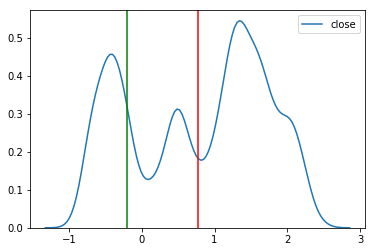

In [6]:
import math
log_price = pd.Series(np.log(original.close))
yearly_returns = (log_price - log_price.shift(365*24*2)).dropna()
sns.kdeplot(yearly_returns)
matplt.axvline(np.mean(yearly_returns), c='red')
matplt.axvline(yearly_returns.quantile(0.25), c='green')

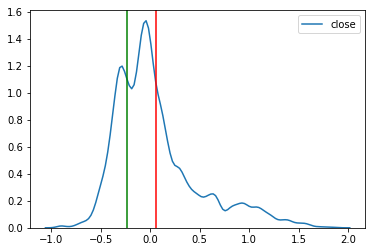

In [81]:
monthly_returns = (log_price - log_price.shift(30*24*2)).dropna()
sns.kdeplot(monthly_returns)
matplt.axvline(np.mean(monthly_returns), c='red')
matplt.axvline(monthly_returns.quantile(0.25), c='green')

At first glance, this distribution seems to have a desireble shape, since if you avoid the downside, you can have potentially unlimited returns. On second thought, that just is because of the hype train that ocurred in the past. I don't think that insane growth is replicable, so the distribution probably doesn't reflect the true distribution. This is the problem with this higher timeframe return rate distributions.

In [ ]:
monthly_returns = (log_price - log_price.shift(7*24*2)).dropna()
sns.kdeplot(monthly_returns)
matplt.axvline(np.mean(monthly_returns), c='red')
matplt.axvline(monthly_returns.quantile(0.25), c='green')

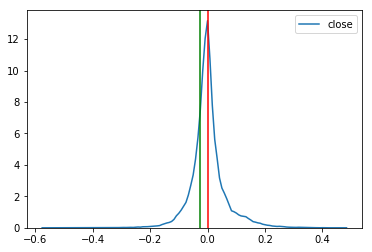

In [79]:
dayly_returns = (log_price - log_price.shift(24*2)).dropna()
sns.kdeplot(dayly_returns)
matplt.axvline(np.mean(dayly_returns), c='red')
matplt.axvline(dayly_returns.quantile(0.25), c='green')

In [78]:
print('mean yearly returns in non-logarithmic:')
math.exp(np.mean(yearly_returns))

mean yearly returns in non-logarithmic:


2.1800882534806756

### With pyalgotrade strategy analyzers

In [6]:
class HODL(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument):
        super(HODL, self).__init__(feed)
        self.getBroker().getFillStrategy().setVolumeLimit(None)
        self.__instrument = instrument
        self.__position = None
#         self.__ma1 = ma.SMA(feed[instrument].getPriceDataSeries(), 56)
#         self.__ma2 = ma.SMA(feed[instrument].getPriceDataSeries(), 28) 
#         self.iter = 0

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        if self.__position is None:
            shares = int(self.getBroker().getCash() * 0.9 / bars[self.__instrument].getPrice())
            self.__position = self.enterLong(self.__instrument, shares, True)

In [7]:
def run_strat(strat, timeframe=(len(original) * barfeed.Frequency.HOUR / 2)):
    retAnalyzer = returns.Returns()
    strat.attachAnalyzer(retAnalyzer)
    sharpeRatioAnalyzer = sharpe.SharpeRatio()
    strat.attachAnalyzer(sharpeRatioAnalyzer)
    drawDownAnalyzer = drawdown.DrawDown()
    strat.attachAnalyzer(drawDownAnalyzer)
    tradesAnalyzer = trades.Trades()
    strat.attachAnalyzer(tradesAnalyzer)

    plt = plotter.StrategyPlotter(strat, True, False, True)

    strat.run()

    plt.plot()
    print("Final portfolio value: $%.2f" % strat.getResult())
    print("Cumulative returns: %.2f %%" % (retAnalyzer.getCumulativeReturns()[-1] * 100))
    print("Expected monthly returns: %.2f %%" % (math.pow(1 + retAnalyzer.getCumulativeReturns()[-1],
                                                          barfeed.Frequency.MONTH / timeframe) * 100 - 100))
    print("Expected yearly returns: %.2f %%" % (math.pow(1 + retAnalyzer.getCumulativeReturns()[-1],
                                                          barfeed.Frequency.DAY * 365 / timeframe) * 100 - 100))
    print("Sharpe ratio: %.2f" % (sharpeRatioAnalyzer.getSharpeRatio(0.05)))
    print("Max. drawdown: %.2f %%" % (drawDownAnalyzer.getMaxDrawDown() * 100))
    print("Longest drawdown duration: %s" % (drawDownAnalyzer.getLongestDrawDownDuration()))

    print("")
    print("Total trades: %d" % (tradesAnalyzer.getCount()))
    if tradesAnalyzer.getCount() > 0:
        profits = tradesAnalyzer.getAll()
        print("Avg. profit: $%2.f" % (profits.mean()))
        print("Profits std. dev.: $%2.f" % (profits.std()))
        print("Max. profit: $%2.f" % (profits.max()))
        print("Min. profit: $%2.f" % (profits.min()))
        ret = tradesAnalyzer.getAllReturns()
        print("Avg. return: %2.f %%" % (ret.mean() * 100))
        print("Returns std. dev.: %2.f %%" % (ret.std() * 100))
        print("Max. return: %2.f %%" % (ret.max() * 100))
        print("Min. return: %2.f %%" % (ret.min() * 100))

    print("")
    print("Profitable trades: %d" % (tradesAnalyzer.getProfitableCount()))
    if tradesAnalyzer.getProfitableCount() > 0:
        profits = tradesAnalyzer.getProfits()
        print("Avg. profit: $%2.f" % (profits.mean()))
        print("Profits std. dev.: $%2.f" % (profits.std()))
        print("Max. profit: $%2.f" % (profits.max()))
        print("Min. profit: $%2.f" % (profits.min()))
        ret = tradesAnalyzer.getPositiveReturns()
        print("Avg. return: %2.f %%" % (ret.mean() * 100))
        print("Returns std. dev.: %2.f %%" % (ret.std() * 100))
        print("Max. return: %2.f %%" % (ret.max() * 100))
        print("Min. return: %2.f %%" % (ret.min() * 100))

    print("")
    print("Unprofitable trades: %d" % (tradesAnalyzer.getUnprofitableCount()))
    if tradesAnalyzer.getUnprofitableCount() > 0:
        losses = tradesAnalyzer.getLosses()
        print("Avg. loss: $%2.f" % (losses.mean()))
        print("Losses std. dev.: $%2.f" % (losses.std()))
        print("Max. loss: $%2.f" % (losses.min()))
        print("Min. loss: $%2.f" % (losses.max()))
        ret = tradesAnalyzer.getNegativeReturns()
        print("Avg. return: %2.f %%" % (ret.mean() * 100))
        print("Returns std. dev.: %2.f %%" % (ret.std() * 100))
        print("Max. return: %2.f %%" % (ret.max() * 100))
        print("Min. return: %2.f %%" % (ret.min() * 100))

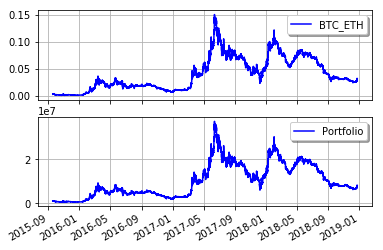

Final portfolio value: $8117056.39
Cumulative returns: 711.71 %
Expected monthly returns: 5.60 %
Expected yearly returns: 89.88 %
Sharpe ratio: 0.87
Max. drawdown: 83.91 %
Longest drawdown duration: 558 days 20:00:00

Total trades: 0

Profitable trades: 0

Unprofitable trades: 0


In [8]:
instrument = 'BTC_ETH'
feed = DataFrameBarFeed(original, instrument, barfeed.Frequency.HOUR / 2)
hodl = HODL(feed, instrument)
run_strat(hodl)

## RSI2 sample strategy

Oh, a sample strategy, I hope it is not too bad. **HOLY SHIT CUMULATIVE RETURNS OF 2500% AND A MUCH BETTER RISK PROFILE THAN HODLING!!!!**

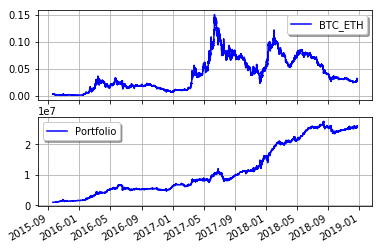

Final portfolio value: $25939201.29
Cumulative returns: 2493.92 %
Expected monthly returns: 8.84 %
Expected yearly returns: 171.01 %
Sharpe ratio: 2.05
Max. drawdown: 34.43 %
Longest drawdown duration: 220 days 14:30:00

Total trades: 2271
Avg. profit: $10982
Profits std. dev.: $129230
Max. profit: $713708
Min. profit: $-1250240
Avg. return:  0 %
Returns std. dev.:  2 %
Max. return: 11 %
Min. return: -16 %

Profitable trades: 1531
Avg. profit: $64856
Profits std. dev.: $70428
Max. profit: $713708
Min. profit: $ 2
Avg. return:  1 %
Returns std. dev.:  1 %
Max. return: 11 %
Min. return:  0 %

Unprofitable trades: 739
Avg. loss: $-100617
Losses std. dev.: $150260
Max. loss: $-1250240
Min. loss: $-9
Avg. return: -1 %
Returns std. dev.:  2 %
Max. return: -0 %
Min. return: -16 %


In [9]:
instrument = 'BTC_ETH'
feed = DataFrameBarFeed(original, instrument, barfeed.Frequency.HOUR / 2)
entrySMA = 200
exitSMA = 5
rsiPeriod = 2
overBoughtThreshold = 90
overSoldThreshold = 10

strat = rsi2.RSI2(feed, instrument, entrySMA, exitSMA, rsiPeriod, overBoughtThreshold, overSoldThreshold)
run_strat(strat)

In [31]:
barfeed.Frequency.MONTH / barfeed.Frequency.HOUR * 2

1488.0

In [37]:
(len(original) * barfeed.Frequency.HOUR / 2) / barfeed.Frequency.MONTH

38.450268817204304

In [40]:
original.tail()

close                date      high       low      open  \
57209  0.032398 2018-12-23 17:30:00  0.032440  0.032264  0.032279   
57210  0.032335 2018-12-23 18:00:00  0.032388  0.032264  0.032384   
57211  0.032439 2018-12-23 18:30:00  0.032456  0.032341  0.032373   
57212  0.032444 2018-12-23 19:00:00  0.032473  0.032398  0.032403   
57213  0.032380 2018-12-23 19:30:00  0.032444  0.032356  0.032444   

       quoteVolume    volume  weightedAverage  
57209   167.521008  5.415495         0.032327  
57210    59.336265  1.919648         0.032352  
57211   188.175282  6.101123         0.032423  
57212   157.947252  5.122461         0.032431  
57213    60.197846  1.950349         0.032399

running on last 36 months


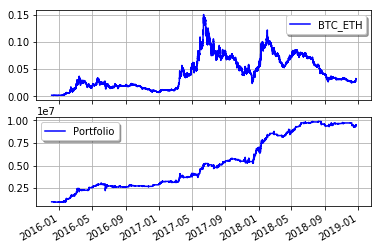

Final portfolio value: $9485443.25
Cumulative returns: 848.54 %
Expected monthly returns: 6.45 %
Expected yearly returns: 108.72 %
Sharpe ratio: 2.05
Max. drawdown: 27.18 %
Longest drawdown duration: 215 days 17:00:00

Total trades: 1006
Avg. profit: $8435
Profits std. dev.: $56495
Max. profit: $305674
Min. profit: $-425287
Avg. return:  0 %
Returns std. dev.:  2 %
Max. return: 11 %
Min. return: -16 %

Profitable trades: 670
Avg. profit: $33635
Profits std. dev.: $35402
Max. profit: $305674
Min. profit: $ 1
Avg. return:  1 %
Returns std. dev.:  1 %
Max. return: 11 %
Min. return:  0 %

Unprofitable trades: 335
Avg. loss: $-41940
Losses std. dev.: $57184
Max. loss: $-425287
Min. loss: $-203
Avg. return: -1 %
Returns std. dev.:  1 %
Max. return: -0 %
Min. return: -16 %
running on last 8 months


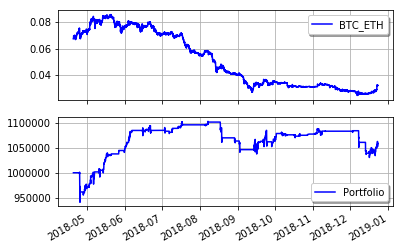

Final portfolio value: $1059288.72
Cumulative returns: 5.93 %
Expected monthly returns: 0.72 %
Expected yearly returns: 8.85 %
Sharpe ratio: 0.15
Max. drawdown: 6.61 %
Longest drawdown duration: 138 days 08:00:00

Total trades: 181
Avg. profit: $328
Profits std. dev.: $5658
Max. profit: $12656
Min. profit: $-27540
Avg. return:  0 %
Returns std. dev.:  1 %
Max. return:  1 %
Min. return: -3 %

Profitable trades: 125
Avg. profit: $2929
Profits std. dev.: $2365
Max. profit: $12656
Min. profit: $111
Avg. return:  0 %
Returns std. dev.:  0 %
Max. return:  1 %
Min. return:  0 %

Unprofitable trades: 56
Avg. loss: $-5478
Losses std. dev.: $6495
Max. loss: $-27540
Min. loss: $-23
Avg. return: -1 %
Returns std. dev.:  1 %
Max. return: -0 %
Min. return: -3 %


In [10]:
for i in [3 * 12, 8]:
    index = int(i * (barfeed.Frequency.MONTH / barfeed.Frequency.HOUR) * 2)
    print("running on last {} months".format(i))
    instrument = 'BTC_ETH'
    feed = DataFrameBarFeed(original[-index:].reset_index(), instrument, barfeed.Frequency.HOUR / 2)
    entrySMA = 200
    exitSMA = 5
    rsiPeriod = 2
    overBoughtThreshold = 90
    overSoldThreshold = 10

    strat = rsi2.RSI2NoShort(feed, instrument, entrySMA, exitSMA, rsiPeriod, overBoughtThreshold, overSoldThreshold)
    run_strat(strat, len(original[-index:]) * barfeed.Frequency.HOUR / 2)

## Using technical indicator predictor

In [147]:
df = pd.read_json('../data/raw/BTC_ETH.json')
df['preds'] = pd.read_hdf('../data/predictions/technical_indicators1.h5', key='predictions')
df = df.dropna().reset_index()

In [10]:
class Predictor(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument, enter_threashold=0.5, exit_threashold=0.5):
        super(Predictor, self).__init__(feed)
        self.getBroker().getFillStrategy().setVolumeLimit(None)
        self.__instrument = instrument
        self.__position = None
        self.enter_threashold = enter_threashold
        self.exit_threashold = exit_threashold
        self.iter = 0

    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        bar = bars[self.__instrument]
        if self.__position is not None:
            if df.preds[self.iter] < self.exit_threashold:
                self.__position.exitMarket()
        else:
            if df.preds[self.iter] > self.enter_threashold:
                shares = int(self.getBroker().getCash() * 0.9 / bars[self.__instrument].getPrice())
                self.__position = self.enterLong(self.__instrument, shares, True)
        
        self.iter += 1

In [150]:
df['log_diff'] = pd.Series(np.log(df.close)).diff().shift(-1)

In [151]:
metrics.accuracy_score(df.log_diff > 0, df.preds > 0.5)

0.5375328083989501

Funnyly enough, you can predict most of the models predictions by predicting the opposite of what just happened.

In [152]:
metrics.accuracy_score(df.log_diff.shift(1) < 0, df.preds > 0.5)

0.7199580052493438

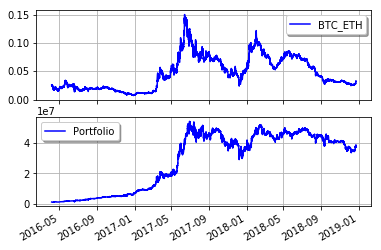

Final portfolio value: $38280610.36
Cumulative returns: 3728.06 %
Expected monthly returns: 9.94 %
Expected yearly returns: 205.31 %
Sharpe ratio: 1.95
Max. drawdown: 46.54 %
Longest drawdown duration: 542 days 15:30:00

Total trades: 9165
Avg. profit: $4068
Profits std. dev.: $296380
Max. profit: $2948209
Min. profit: $-5277666
Avg. return:  0 %
Returns std. dev.:  1 %
Max. return: 13 %
Min. return: -17 %

Profitable trades: 5444
Avg. profit: $120263
Profits std. dev.: $206743
Max. profit: $2948209
Min. profit: $ 4
Avg. return:  1 %
Returns std. dev.:  1 %
Max. return: 13 %
Min. return:  0 %

Unprofitable trades: 3703
Avg. loss: $-166738
Losses std. dev.: $324878
Max. loss: $-5277666
Min. loss: $-3
Avg. return: -1 %
Returns std. dev.:  1 %
Max. return: -0 %
Min. return: -17 %


In [153]:
instrument = 'BTC_ETH'
feed = DataFrameBarFeed(original, instrument, barfeed.Frequency.HOUR / 2)

strat = Predictor(feed, instrument)
run_strat(strat)

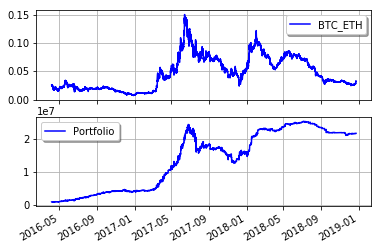

Final portfolio value: $21561692.83
Cumulative returns: 2056.17 %
Expected monthly returns: 8.31 %
Expected yearly returns: 156.09 %
Sharpe ratio: 2.31
Max. drawdown: 47.55 %
Longest drawdown duration: 316 days 13:30:00

Total trades: 3175
Avg. profit: $6476
Profits std. dev.: $134476
Max. profit: $1363688
Min. profit: $-1906821
Avg. return:  0 %
Returns std. dev.:  1 %
Max. return: 11 %
Min. return: -15 %

Profitable trades: 1977
Avg. profit: $52576
Profits std. dev.: $102808
Max. profit: $1363688
Min. profit: $ 2
Avg. return:  1 %
Returns std. dev.:  1 %
Max. return: 11 %
Min. return:  0 %

Unprofitable trades: 1196
Avg. loss: $-69717
Losses std. dev.: $145660
Max. loss: $-1906821
Min. loss: $-21
Avg. return: -1 %
Returns std. dev.:  1 %
Max. return: -0 %
Min. return: -15 %


In [161]:
instrument = 'BTC_ETH'
feed = DataFrameBarFeed(original, instrument, barfeed.Frequency.HOUR / 2)

strat = Predictor(feed, instrument, enter_threashold=0.6, exit_threashold=0.55)
run_strat(strat)

In [166]:
class Quasitrivial(strategy.BacktestingStrategy):
    def __init__(self, feed, instrument):
        super(Quasitrivial, self).__init__(feed)
        self.getBroker().getFillStrategy().setVolumeLimit(None)
        self.__instrument = instrument
        self.__position = None
        self.__priceDS = feed[instrument].getPriceDataSeries()
        
    def onEnterCanceled(self, position):
        self.__position = None

    def onExitOk(self, position):
        self.__position = None

    def onExitCanceled(self, position):
        # If the exit was canceled, re-submit it.
        self.__position.exitMarket()

    def onBars(self, bars):
        bar = bars[self.__instrument]
        if len(self.__priceDS) > 2:
            if self.__position is not None:
                if self.__priceDS[-1] > self.__priceDS[-2]:
                    self.__position.exitMarket()
            else:
                if self.__priceDS[-1] < self.__priceDS[-2]:
                    shares = int(self.getBroker().getCash() * 0.9 / bars[self.__instrument].getPrice())
                    self.__position = self.enterLong(self.__instrument, shares, True)
        

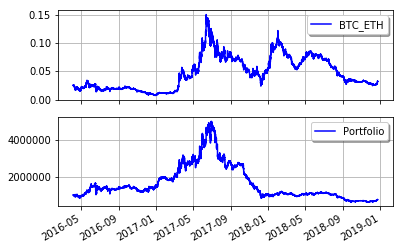

Final portfolio value: $732913.83
Cumulative returns: -26.71 %
Expected monthly returns: -0.80 %
Expected yearly returns: -9.08 %
Sharpe ratio: 0.01
Max. drawdown: 88.29 %
Longest drawdown duration: 542 days 13:00:00

Total trades: 12501
Avg. profit: $-21
Profits std. dev.: $19836
Max. profit: $278105
Min. profit: $-483930
Avg. return:  0 %
Returns std. dev.:  1 %
Max. return: 13 %
Min. return: -19 %

Profitable trades: 7632
Avg. profit: $7349
Profits std. dev.: $13473
Max. profit: $278105
Min. profit: $ 0
Avg. return:  0 %
Returns std. dev.:  1 %
Max. return: 13 %
Min. return:  0 %

Unprofitable trades: 4846
Avg. loss: $-11629
Losses std. dev.: $22556
Max. loss: $-483930
Min. loss: $-0
Avg. return: -1 %
Returns std. dev.:  1 %
Max. return: -0 %
Min. return: -19 %


In [167]:
instrument = 'BTC_ETH'
feed = DataFrameBarFeed(original, instrument, barfeed.Frequency.HOUR / 2)

strat = Quasitrivial(feed, instrument)
run_strat(strat)

## Regression

In [8]:
df = pd.read_json('../data/raw/BTC_ETH.json')
df['preds'] = pd.read_hdf('../data/predictions/regression_indicators1.h5', key='predictions')
df = df.dropna().reset_index()

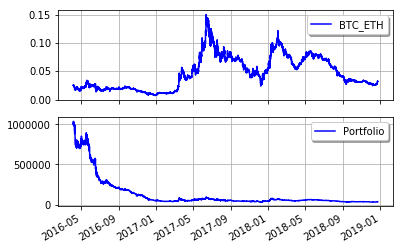

Final portfolio value: $35383.51
Cumulative returns: -96.46 %
Expected monthly returns: -8.32 %
Expected yearly returns: -64.06 %
Sharpe ratio: -1.32
Max. drawdown: 97.31 %
Longest drawdown duration: 991 days 07:30:00

Total trades: 9143
Avg. profit: $-106
Profits std. dev.: $2886
Max. profit: $76547
Min. profit: $-41285
Avg. return: -0 %
Returns std. dev.:  1 %
Max. return: 17 %
Min. return: -12 %

Profitable trades: 3417
Avg. profit: $1087
Profits std. dev.: $3390
Max. profit: $76547
Min. profit: $ 0
Avg. return:  1 %
Returns std. dev.:  1 %
Max. return: 17 %
Min. return:  0 %

Unprofitable trades: 5712
Avg. loss: $-819
Losses std. dev.: $2258
Max. loss: $-41285
Min. loss: $-0
Avg. return: -1 %
Returns std. dev.:  1 %
Max. return: -0 %
Min. return: -12 %


In [11]:
feed = DataFrameBarFeed(df, instrument, barfeed.Frequency.HOUR / 2)

strat = Predictor(feed, instrument, enter_threashold=0, exit_threashold=0)
run_strat(strat)